<a href="https://colab.research.google.com/github/cychen116/DataAnalysis_practice/blob/main/14_ML_NaiveBayes_BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice dataset

Wisconsin Breast Cancer Dataset https://www.kaggle.com/priyanka841/breast-cancer-wisconsin ✓

Look at distribution of features and seee if normal/gausssian fits. If not -- what distribution should we use? ✓

Play with feature selection -- what features contribute to improvement and what don't? ✓

Use k-fold to validate ✓

In [58]:
#Data Basic
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

In [4]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = "/content/drive/MyDrive/Colab Notebooks/EMSE 6575/Data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: ls/content/drive/MyDrive/Colab Notebooks/EMSE 6575/Data: No such file or directory


# Loading Data

In [10]:
data = pd.read_csv(data_dir + '/breast_cancer_data.csv')
data.drop(columns=["Unnamed: 32"],inplace=True)
print(data.shape)
data.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [11]:
data.info()
#No null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

#EDA

## Examine the covariates with pair-wise scatter plots to check for correlated variables

In [50]:
cols = data.drop(columns=['id']).columns.to_list()
features_mean = [x for x in cols if "mean" in x]
features_se = [x for x in cols if "se" in x]
features_worst = [x for x in cols if "worst" in x]

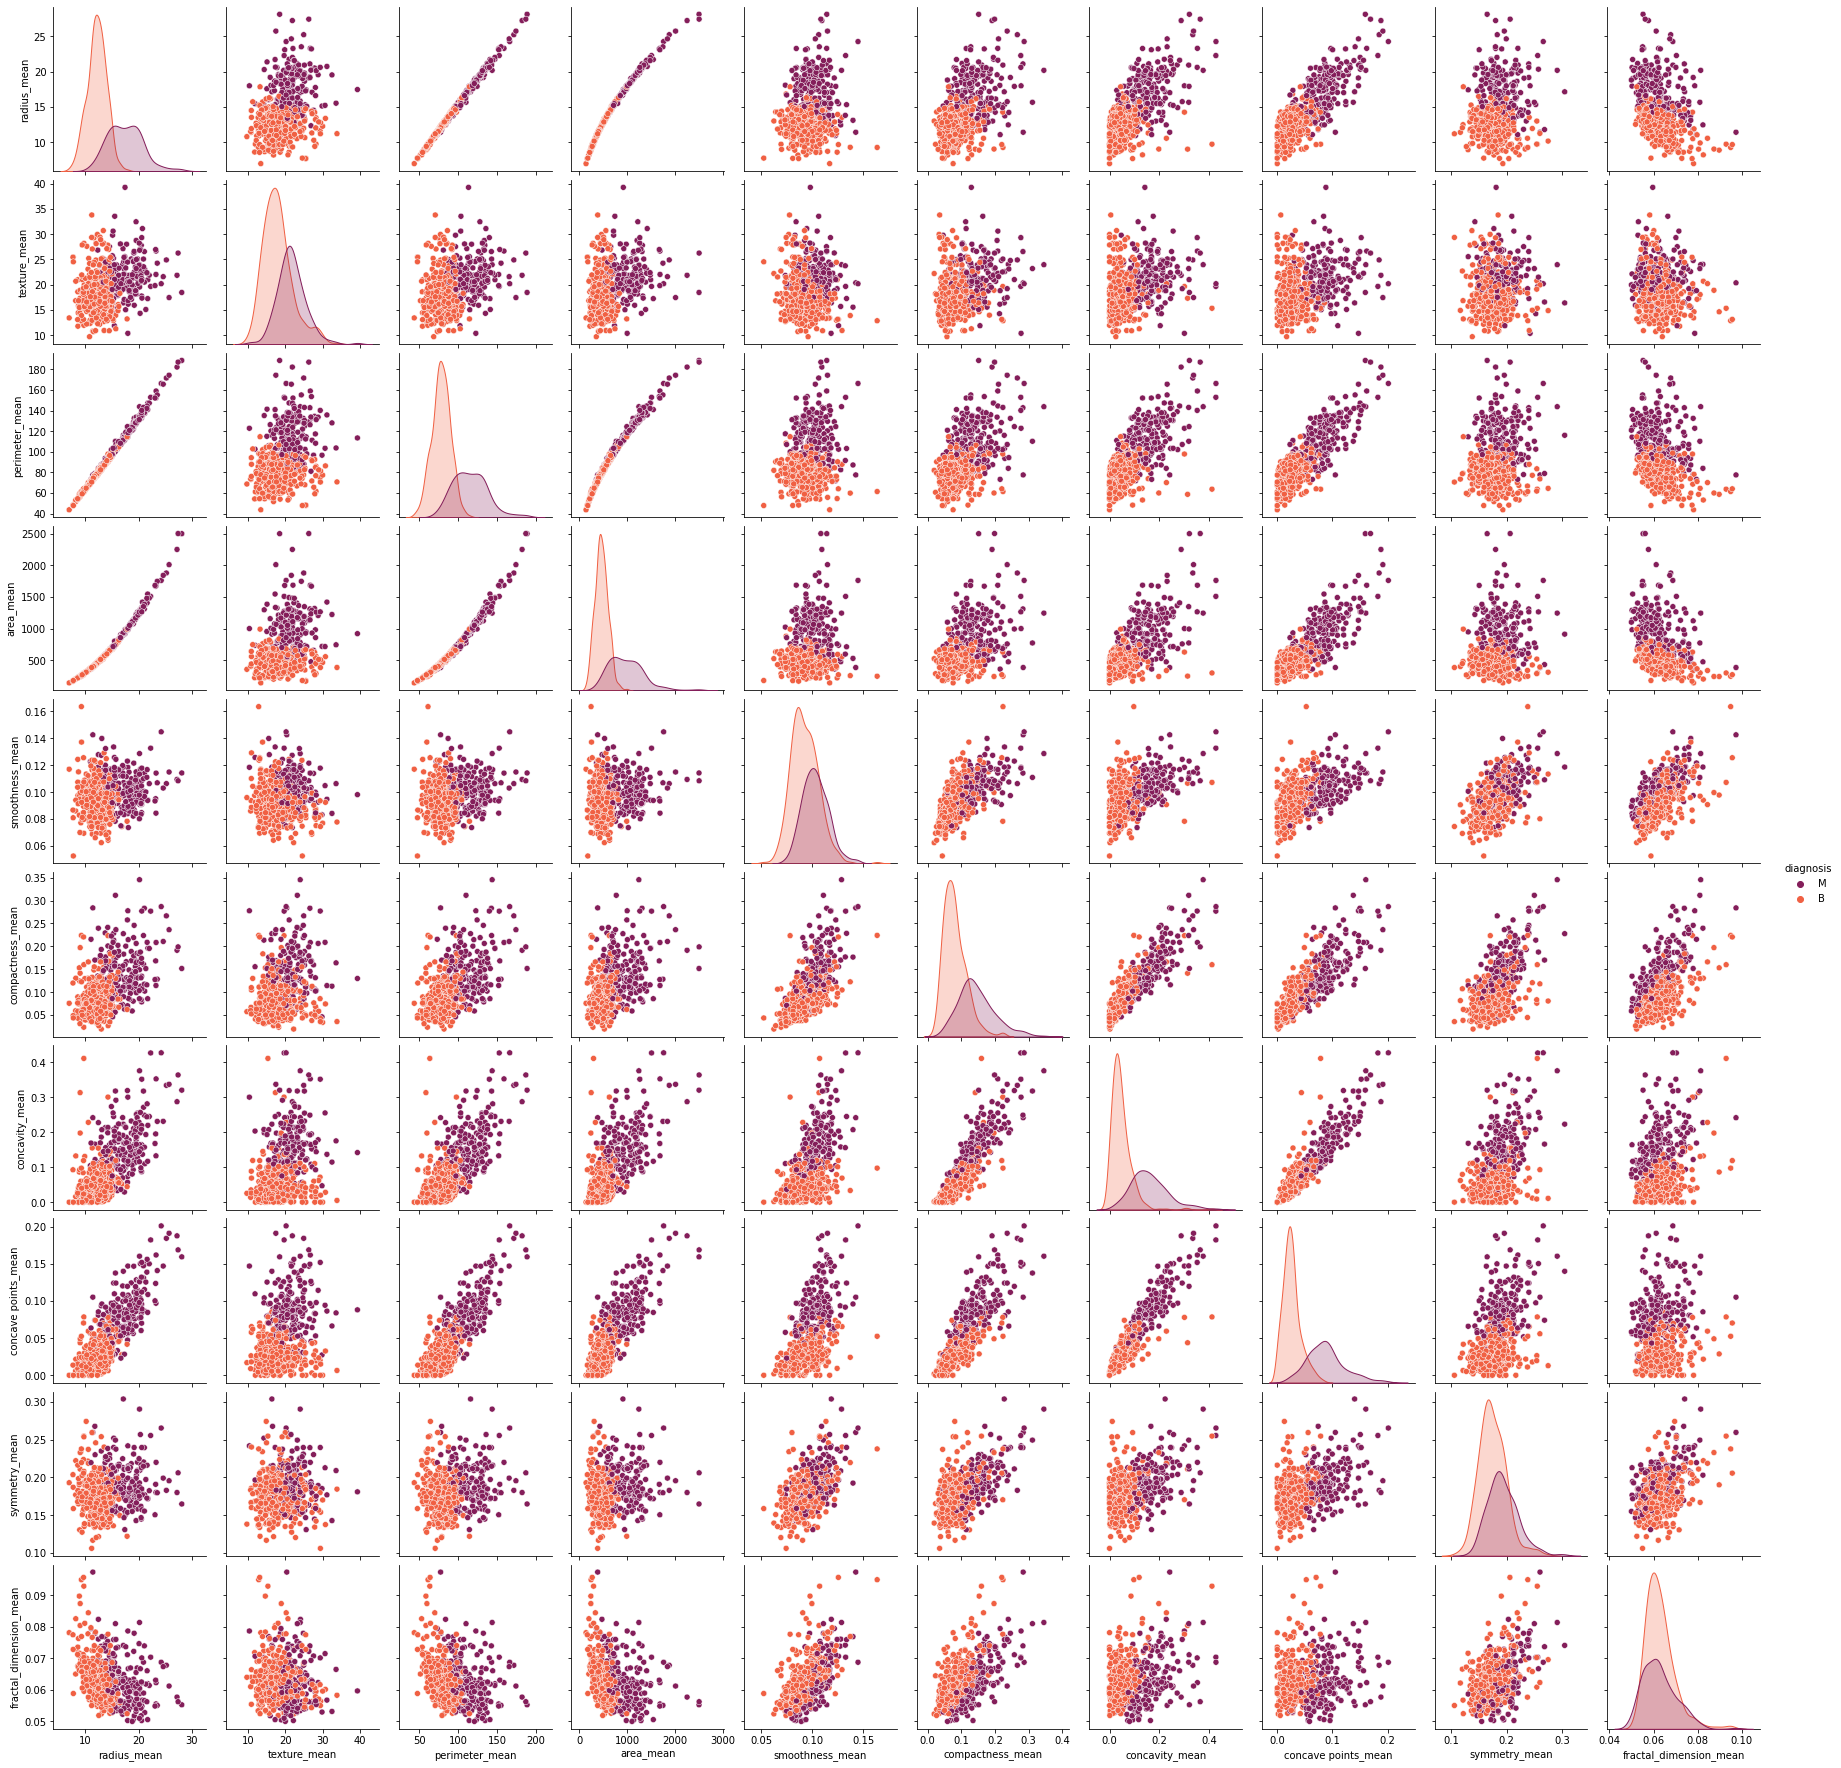

In [24]:
#features_mean.insert(0, "diagnosis")
sns.pairplot(data=data[['diagnosis']+features_mean], hue='diagnosis', palette='rocket')

## Remove highly correlated variables

In [29]:
data.drop(columns=['id','diagnosis']).head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


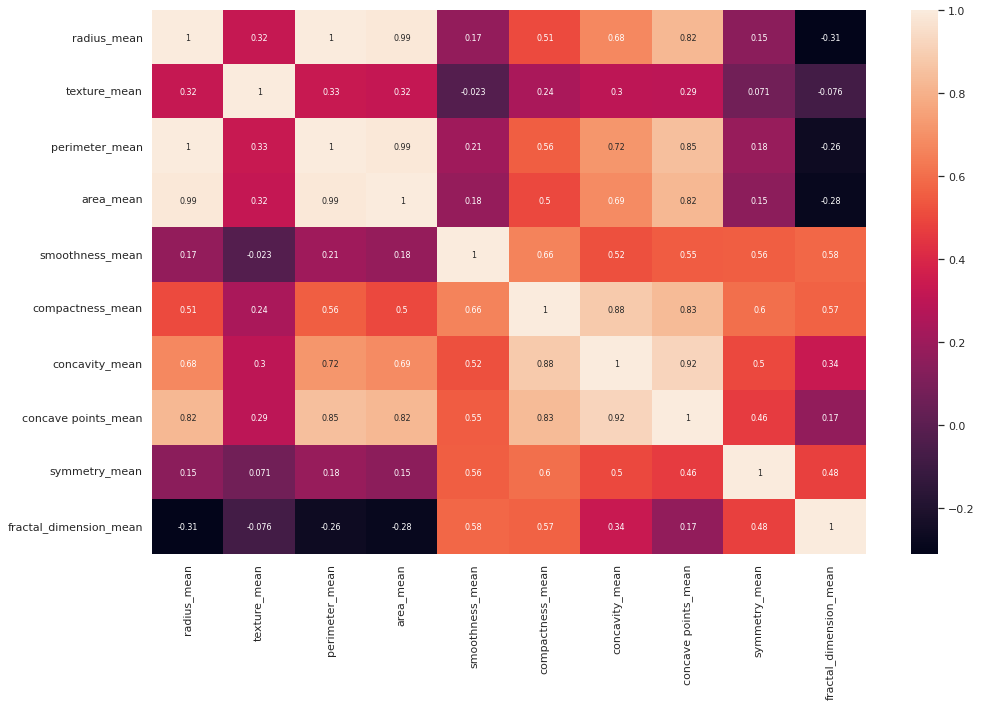

In [42]:
corr = data[features_mean].corr()
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(corr, annot=True, annot_kws={"size": 8})

### Radius vs Perimeter vs Area 

In [35]:
data[['radius_mean', 'perimeter_mean', 'area_mean']].corr()

,radius_mean,perimeter_mean,area_mean
radius_mean,1.000000,0.997855,0.987357
perimeter_mean,0.997855,1.000000,0.986507
area_mean,0.987357,0.986507,1.000000


Radius, perimeter, and area are highly correlated with other.  Since the formula for perimeter is 2πr, and r is the radius. Likewise, the formula for area is πr^2. Due to the multi-collinearity between variables, we'll pick just one of these 3. 

Hense perimeter and area are all affect by radius, we should pick radius as the representive of these three features.

### Compactness vs Concavity vs Concave Points

Besides the group of radius, compactness, concavity and concave points are another group of features is high correlaed to wach other.

In [38]:
data[['compactness_mean', 'concavity_mean', 'concave points_mean']].corr()

,compactness_mean,concavity_mean,concave points_mean
compactness_mean,1.000000,0.883121,0.831135
concavity_mean,0.883121,1.000000,0.921391
concave points_mean,0.831135,0.921391,1.000000


The correlation between concavity and concave points are highest among this group. We will drop one of them. Since concavity has higher correlation with compactness than concave points, we will drop concavity in this group.

### Remove Other Features that Correlation is Greater than 0.8
based on mean

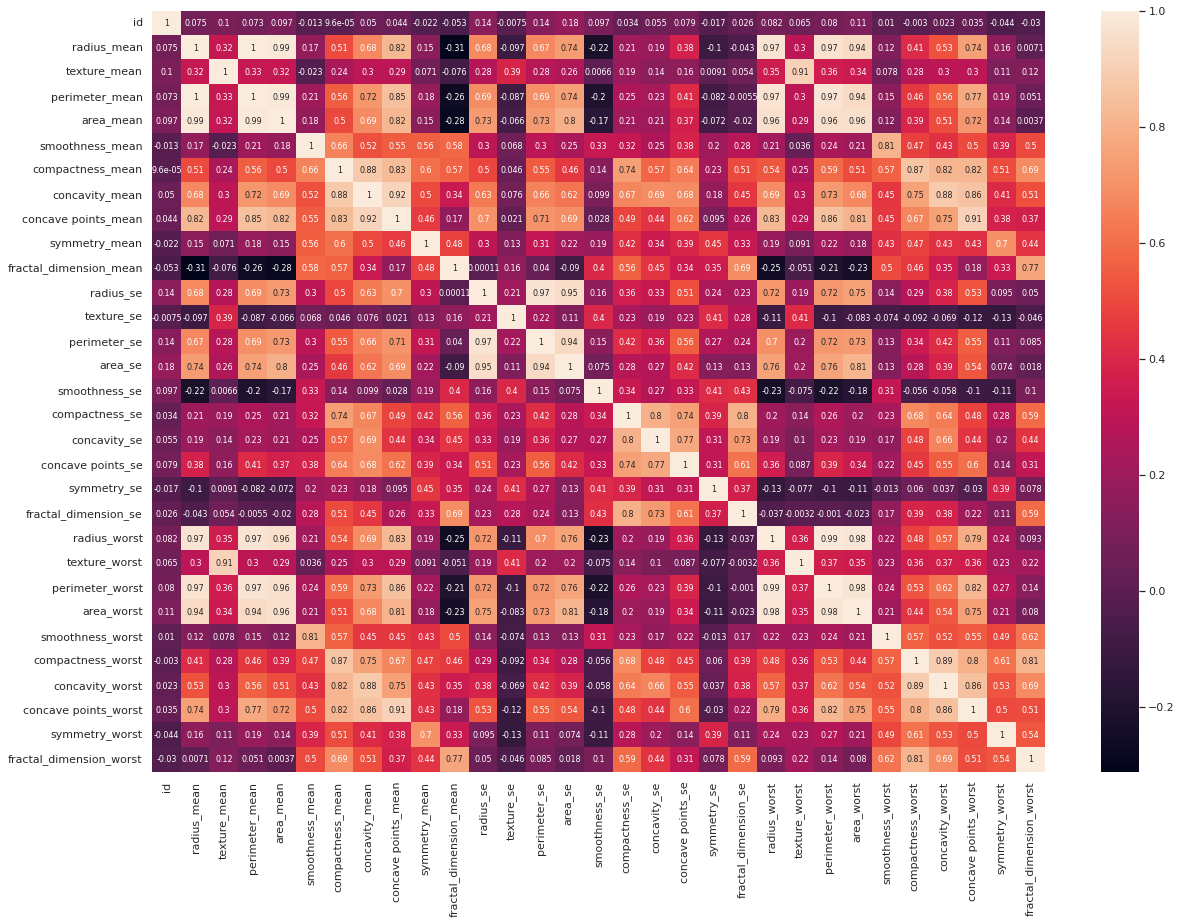

In [46]:
corr = data.corr()
sns.set(rc = {'figure.figsize':(20,14)})
sns.heatmap(corr, annot=True, annot_kws={"size": 8})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


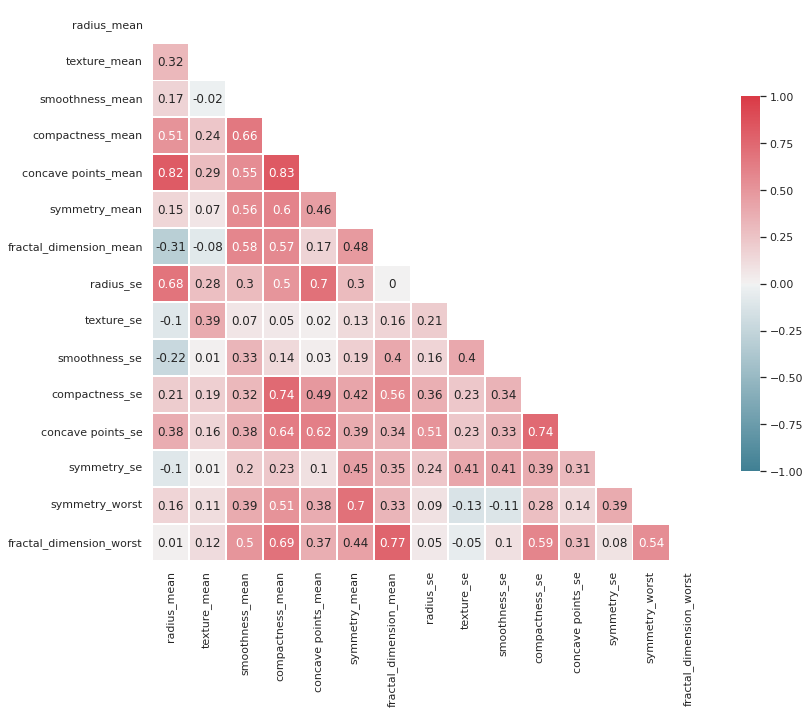

In [59]:
features_mean = ['radius_mean',
                'texture_mean',
                #'perimeter_mean',
                #'area_mean',
                'smoothness_mean',
                'compactness_mean',
                #'concavity_mean',
                'concave points_mean',
                'symmetry_mean',
                'fractal_dimension_mean'
                ]

features_se = ['radius_se',
                'texture_se',
                #'perimeter_se',
                #'area_se',
                'smoothness_se',
                'compactness_se',
                #'concavity_se',
                'concave points_se',
                'symmetry_se',
                #'fractal_dimension_se'
                ]

features_worst = [#'radius_worst',
                  #'texture_worst',
                  #'perimeter_worst',
                  #'area_worst',
                  #'smoothness_worst',
                  #'compactness_worst',
                  #'concavity_worst',
                  #'concave points_worst',
                  'symmetry_worst',
                  'fractal_dimension_worst'
                  ]

df = data[['diagnosis']+ features_mean + features_se+ features_worst]

corr = df.corr().round(2)

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(12, 12))

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

## Feature scaling

In [60]:
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#sc = StandardScaler() 
sc = MinMaxScaler() 

# standardize features
X = df.drop(['diagnosis'], axis=1)
X_transformed = StandardScaler().fit_transform(X)
X=pd.DataFrame(X_transformed,columns=X.columns)
X.head()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concave points_se,symmetry_se,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,1.568466,3.283515,2.532475,2.217515,2.255747,2.489734,-0.565265,-0.214002,1.316862,0.660820,1.148757,2.750622,1.937015
1,1.829821,-0.353632,-0.826962,-0.487072,0.548144,0.001392,-0.868652,0.499255,-0.876244,-0.605351,-0.692926,0.260162,-0.805450,-0.243890,0.281190
2,1.579888,0.456187,0.942210,1.052926,2.037231,0.939685,-0.398008,1.228676,-0.780083,-0.297005,0.814974,1.424827,0.237036,1.152255,0.201391
3,-0.768909,0.253732,3.283553,3.402909,1.451707,2.867383,4.910919,0.326373,-0.110409,0.689702,2.744280,1.115007,4.732680,6.046041,4.935010
4,1.750297,-1.151816,0.280372,0.539340,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.483067,-0.048520,1.144205,-0.361092,-0.868353,-0.397100


In [61]:
# Transform cancer diagnosis to 1 and 0
df['diagnosis'].value_counts()
def dichotomize(txt):
  val = 0
  if txt == 'M':
    val = 1
  return(val)
  
df['diagnosis'] = df['diagnosis'].apply(lambda x: dichotomize(x))
y = df['diagnosis']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# Model training

In [63]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from statistics import mean
from numpy import std

In [64]:
def eval_model(model, print_text, X, y):
  cv = KFold(n_splits=10) 
  accuracy = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv)
  accuracy = list(accuracy)
  f1_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
  f1_scores = list(f1_scores)
  precision_scores = cross_val_score(model, X, y, scoring = 'precision', cv = cv)
  precision_scores = list(precision_scores)
  recall_scores = cross_val_score(model, X, y, scoring = 'recall', cv = cv)
  recall_scores = list(recall_scores)

  print(print_text)
  print('accuracy score: ' + str(mean(accuracy))[0:5] + " +/- " + str(std(accuracy))[0:5])
  print('f1 score: ' + str(mean(f1_scores))[0:5] + " +/- " + str(std(f1_scores))[0:5])
  print('precision: ' + str(mean(precision_scores))[0:5] + " +/- " + str(std(precision_scores))[0:5])
  print('recall: '+ str(mean(recall_scores))[0:5] + " +/- " + str(std(recall_scores))[0:5] + "\n")

In [65]:
eval_model(model = GaussianNB(), X = X, y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X, y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X, y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X, y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X, y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.905 +/- 0.034
f1 score: 0.864 +/- 0.038
precision: 0.859 +/- 0.068
recall: 0.876 +/- 0.060

Logistic Regression
accuracy score: 0.956 +/- 0.028
f1 score: 0.937 +/- 0.040
precision: 0.945 +/- 0.053
recall: 0.932 +/- 0.050

Support Vector Machine
accuracy score: 0.959 +/- 0.023
f1 score: 0.942 +/- 0.035
precision: 0.940 +/- 0.046
recall: 0.944 +/- 0.042

Random Forest
accuracy score: 0.938 +/- 0.034
f1 score: 0.915 +/- 0.038
precision: 0.941 +/- 0.060
recall: 0.922 +/- 0.044

KNN
accuracy score: 0.938 +/- 0.023
f1 score: 0.904 +/- 0.044
precision: 0.938 +/- 0.054
recall: 0.876 +/- 0.054



From this data set and the feature we select, we can tell that Support Vector Machine has the best result; and Logistic Regression is the second.

## Using Logistic Model to Reduce Features

In [66]:
# Implement the model
import statsmodels.api as sm
logit_model=sm.Logit(y, X)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.066777
         Iterations 11
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.899      
Dependent Variable:    diagnosis         AIC:               105.9922   
Date:                  2022-03-06 05:15  BIC:               171.1504   
No. Observations:      569               Log-Likelihood:    -37.996    
Df Model:              14                LL-Null:           -375.72    
Df Residuals:          554               LLR p-value:       4.4687e-135
Converged:             1.0000            Scale:             1.0000     
No. Iterations:        11.0000                                         
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
radius_mean              2.0864   1.3026  1.6017 0.1092 -0.466

In [69]:
drop_cols = ['smoothness_mean']
eval_model(model = GaussianNB(), X = X.drop(drop_cols, axis=1), y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X.drop(drop_cols, axis=1), y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X.drop(drop_cols, axis=1), y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.906 +/- 0.039
f1 score: 0.870 +/- 0.037
precision: 0.872 +/- 0.079
recall: 0.876 +/- 0.060

Logistic Regression
accuracy score: 0.959 +/- 0.023
f1 score: 0.942 +/- 0.036
precision: 0.952 +/- 0.045
recall: 0.935 +/- 0.051

Support Vector Machine
accuracy score: 0.957 +/- 0.026
f1 score: 0.938 +/- 0.047
precision: 0.945 +/- 0.063
recall: 0.934 +/- 0.054

Random Forest
accuracy score: 0.945 +/- 0.037
f1 score: 0.926 +/- 0.033
precision: 0.918 +/- 0.059
recall: 0.918 +/- 0.047

KNN
accuracy score: 0.936 +/- 0.027
f1 score: 0.901 +/- 0.041
precision: 0.932 +/- 0.050
recall: 0.874 +/- 0.043



After we drop the one feature with highist, `smoothness_mean` , Naive Bayesm, Logistic Regression and Random Forest model got slight improvement. Let's drop more and see the results.


In [70]:
drop_cols = ['smoothness_mean', 'concave points_se']
eval_model(model = GaussianNB(), X = X.drop(drop_cols, axis=1), y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X.drop(drop_cols, axis=1), y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X.drop(drop_cols, axis=1), y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.910 +/- 0.037
f1 score: 0.874 +/- 0.038
precision: 0.880 +/- 0.085
recall: 0.877 +/- 0.057

Logistic Regression
accuracy score: 0.961 +/- 0.023
f1 score: 0.947 +/- 0.029
precision: 0.953 +/- 0.044
recall: 0.943 +/- 0.040

Support Vector Machine
accuracy score: 0.963 +/- 0.024
f1 score: 0.946 +/- 0.041
precision: 0.955 +/- 0.047
recall: 0.938 +/- 0.052

Random Forest
accuracy score: 0.942 +/- 0.033
f1 score: 0.924 +/- 0.035
precision: 0.931 +/- 0.064
recall: 0.904 +/- 0.048

KNN
accuracy score: 0.940 +/- 0.026
f1 score: 0.907 +/- 0.035
precision: 0.943 +/- 0.047
recall: 0.875 +/- 0.045



In [71]:
drop_cols = ['smoothness_mean', 'concave points_se', 'texture_se']
eval_model(model = GaussianNB(), X = X.drop(drop_cols, axis=1), y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X.drop(drop_cols, axis=1), y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X.drop(drop_cols, axis=1), y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.908 +/- 0.039
f1 score: 0.873 +/- 0.037
precision: 0.880 +/- 0.085
recall: 0.875 +/- 0.059

Logistic Regression
accuracy score: 0.964 +/- 0.022
f1 score: 0.951 +/- 0.029
precision: 0.959 +/- 0.035
recall: 0.945 +/- 0.038

Support Vector Machine
accuracy score: 0.963 +/- 0.025
f1 score: 0.947 +/- 0.043
precision: 0.950 +/- 0.061
recall: 0.946 +/- 0.043

Random Forest
accuracy score: 0.947 +/- 0.034
f1 score: 0.921 +/- 0.030
precision: 0.934 +/- 0.064
recall: 0.915 +/- 0.036

KNN
accuracy score: 0.950 +/- 0.036
f1 score: 0.928 +/- 0.052
precision: 0.962 +/- 0.053
recall: 0.898 +/- 0.061



In [72]:
drop_cols = ['smoothness_mean', 'concave points_se', 'texture_se','compactness_se']
eval_model(model = GaussianNB(), X = X.drop(drop_cols, axis=1), y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X.drop(drop_cols, axis=1), y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X.drop(drop_cols, axis=1), y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.912 +/- 0.038
f1 score: 0.877 +/- 0.037
precision: 0.883 +/- 0.082
recall: 0.878 +/- 0.059

Logistic Regression
accuracy score: 0.964 +/- 0.022
f1 score: 0.949 +/- 0.036
precision: 0.958 +/- 0.036
recall: 0.942 +/- 0.050

Support Vector Machine
accuracy score: 0.966 +/- 0.021
f1 score: 0.952 +/- 0.027
precision: 0.961 +/- 0.034
recall: 0.946 +/- 0.043

Random Forest
accuracy score: 0.942 +/- 0.031
f1 score: 0.928 +/- 0.040
precision: 0.926 +/- 0.076
recall: 0.907 +/- 0.046

KNN
accuracy score: 0.940 +/- 0.037
f1 score: 0.916 +/- 0.049
precision: 0.932 +/- 0.053
recall: 0.903 +/- 0.069



In [73]:
drop_cols = ['smoothness_mean', 'concave points_se', 'texture_se','compactness_se','smoothness_se']
eval_model(model = GaussianNB(), X = X.drop(drop_cols, axis=1), y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X.drop(drop_cols, axis=1), y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X.drop(drop_cols, axis=1), y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.913 +/- 0.036
f1 score: 0.878 +/- 0.036
precision: 0.887 +/- 0.085
recall: 0.878 +/- 0.057

Logistic Regression
accuracy score: 0.964 +/- 0.023
f1 score: 0.952 +/- 0.030
precision: 0.959 +/- 0.036
recall: 0.945 +/- 0.038

Support Vector Machine
accuracy score: 0.963 +/- 0.021
f1 score: 0.946 +/- 0.032
precision: 0.949 +/- 0.044
recall: 0.946 +/- 0.043

Random Forest
accuracy score: 0.943 +/- 0.031
f1 score: 0.920 +/- 0.042
precision: 0.936 +/- 0.062
recall: 0.932 +/- 0.047

KNN
accuracy score: 0.945 +/- 0.027
f1 score: 0.920 +/- 0.045
precision: 0.944 +/- 0.064
recall: 0.899 +/- 0.036



In [74]:
drop_cols = ['smoothness_mean', 'concave points_se', 'texture_se','compactness_se','smoothness_se','fractal_dimension_mean']
eval_model(model = GaussianNB(), X = X.drop(drop_cols, axis=1), y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X.drop(drop_cols, axis=1), y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X.drop(drop_cols, axis=1), y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.915 +/- 0.038
f1 score: 0.882 +/- 0.038
precision: 0.893 +/- 0.081
recall: 0.878 +/- 0.057

Logistic Regression
accuracy score: 0.961 +/- 0.028
f1 score: 0.947 +/- 0.034
precision: 0.957 +/- 0.047
recall: 0.939 +/- 0.046

Support Vector Machine
accuracy score: 0.966 +/- 0.024
f1 score: 0.950 +/- 0.044
precision: 0.955 +/- 0.063
recall: 0.948 +/- 0.042

Random Forest
accuracy score: 0.949 +/- 0.028
f1 score: 0.927 +/- 0.031
precision: 0.927 +/- 0.071
recall: 0.914 +/- 0.035

KNN
accuracy score: 0.945 +/- 0.026
f1 score: 0.917 +/- 0.044
precision: 0.952 +/- 0.065
recall: 0.887 +/- 0.038



In [75]:
drop_cols = ['smoothness_mean', 'concave points_se', 'texture_se','compactness_se','smoothness_se','fractal_dimension_mean','symmetry_mean']
eval_model(model = GaussianNB(), X = X.drop(drop_cols, axis=1), y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X.drop(drop_cols, axis=1), y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X.drop(drop_cols, axis=1), y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X.drop(drop_cols, axis=1), y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.919 +/- 0.040
f1 score: 0.889 +/- 0.032
precision: 0.897 +/- 0.073
recall: 0.890 +/- 0.056

Logistic Regression
accuracy score: 0.964 +/- 0.026
f1 score: 0.953 +/- 0.030
precision: 0.964 +/- 0.038
recall: 0.943 +/- 0.040

Support Vector Machine
accuracy score: 0.963 +/- 0.024
f1 score: 0.946 +/- 0.042
precision: 0.950 +/- 0.061
recall: 0.945 +/- 0.038

Random Forest
accuracy score: 0.947 +/- 0.028
f1 score: 0.926 +/- 0.030
precision: 0.921 +/- 0.075
recall: 0.923 +/- 0.044

KNN
accuracy score: 0.940 +/- 0.028
f1 score: 0.912 +/- 0.040
precision: 0.943 +/- 0.056
recall: 0.886 +/- 0.052



## Minimum Feature Keep

If wee only keep the one that their p-value is smaller than 0.05, result seems not bad compare the original.
However, the standard deviation increase is higher than other in Naive Bayes Model.

In [77]:
cols_keep = ['texture_mean','concave points_mean', 'radius_se','symmetry_se','symmetry_worst']
X_hat = X[cols_keep]
eval_model(model = GaussianNB(), X = X_hat, y = y, print_text="Naive Bayes")
eval_model(model = LogisticRegression(), X = X_hat, y = y, print_text="Logistic Regression")
eval_model(model = SVC(), X = X_hat, y = y, print_text="Support Vector Machine")
eval_model(model = RandomForestClassifier(), X = X_hat, y = y, print_text="Random Forest")
eval_model(model = KNeighborsClassifier(), X = X_hat, y = y, print_text="KNN")

Naive Bayes
accuracy score: 0.912 +/- 0.047
f1 score: 0.876 +/- 0.057
precision: 0.900 +/- 0.079
recall: 0.859 +/- 0.074

Logistic Regression
accuracy score: 0.950 +/- 0.029
f1 score: 0.932 +/- 0.035
precision: 0.944 +/- 0.045
recall: 0.923 +/- 0.059

Support Vector Machine
accuracy score: 0.956 +/- 0.026
f1 score: 0.938 +/- 0.036
precision: 0.950 +/- 0.058
recall: 0.928 +/- 0.042

Random Forest
accuracy score: 0.935 +/- 0.031
f1 score: 0.908 +/- 0.029
precision: 0.911 +/- 0.071
recall: 0.916 +/- 0.033

KNN
accuracy score: 0.945 +/- 0.032
f1 score: 0.924 +/- 0.031
precision: 0.953 +/- 0.033
recall: 0.901 +/- 0.063

